In [2]:
# 코랩에서 실행할 경우 최신 버전의 사이킷런을 설치합니다.
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [3]:
from IPython.display import Image

In [4]:
Image(url='https://git.io/JtskW', width=500) 

In [5]:
Image(url='https://git.io/Jtskl', width=500)

In [6]:
from scipy.special import comb
import math

In [7]:
def ensemble_error(n_classifier, error):
  k_start = int(math.ceil(n_classifier/2.))
  probs = [comb(n_classifier, k) *
           error**k *
           (1-error)**(n_classifier-k)
           for k in range(k_start, n_classifier+1)]
  return sum(probs)

In [8]:
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

In [9]:
import numpy as np
import matplotlib.pyplot as plt

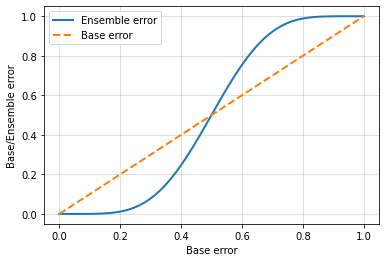

In [10]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]
plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [11]:
np.argmax(np.bincount([0,0,1],
                      weights=[0.2, 0.2, 0.6]))

1

In [12]:
np.bincount([0,0,1])

array([2, 1])

In [13]:
np.bincount([0,0,1], weights=[0.2, 0.2, 0.6])

array([0.4, 0.6])

In [14]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])

p

array([0.58, 0.42])

In [15]:
np.argmax(p)

0

In [16]:
ex = np.array([[0.4, 0.4, 0.2],
               [0.1, 0.8, 0.1],
               [0.1, 0.6, 0.3]])

q = np.average(ex,
               axis=1,
               weights=[0.2, 0.2, 0.6])

q

array([0.28, 0.24, 0.32])

In [17]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [18]:
class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
  """다수결 투표 앙상블 분류기

  매개변수
  ----------
  classifiers : 배열 타입, 크기 = [n_classifiers]
    앙상블에 사용할 분류기
  
  vote : str, {'classlabel', 'probability'}
    기본값: 'classlabel'
    'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
    'probability'면 확률 합이 가장 큰 인덱스로
    클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)

  weights : 배열 타입, 크기 = [n_classifiers]
    선택 사항, 기본값: None
    'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
    'weights=None'이면 동일하게 취급합니다

  """
  def __init__(self, classifiers, vote='classlabel', weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {
        key: value for key, value
        in _name_estimators(classifiers)
    }
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    """분류기를 학습합니다

    매개변수
    ----------
    X : {배열 타입, 희소 행렬},
      크기 = [n_samples, n_features]
      훈련 샘플 행렬

    y : 배열 타입, 크기 = [n_samples]
      타깃 클래스 레이블 벡터

    반환값
    ----------
    self : 객체

    """
    if self.vote not in ('probability', 'classlabel'):
      raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                      f"; (vote={self.vote})이 입력되었습니다.")
    if self.vote and len(self.weights) != len(self.classifiers):
      raise ValueError('분류기와 가중치 갯수는 같아야 합니다'
                      f'; 가중치 {len(self.weights)} 개, 분류기 {len(self.classifiers)} 개')
      
    # self.predict 메서드에서 np.argmax를 호출할 때
    # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
    self.labelenc_ = LabelEncoder()
    self.labelenc_.fit(y)
    self.classes_ = self.labelenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    """X에 대한 클래스 레이블을 예측합니다

    매개변수
    ----------
    X : {배열 타입, 희소 행렬},
      크기 = [n_samples, n_features]
      샘플 데이터 행렬

    반환값
    ----------
    maj_vote : 배열 타입, 크기 = [n_samples]
      예측된 클래스 레이블

    """
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else: # 'classlabel' 투표
      # clf.predict 메서드를 사용하여 결과를 모읍니다
      predictions = np.asarray([
          clf.predict(X) for clf in self.classifiers_
      ]).T

      maj_vote = np.apply_along_axis(
          lambda x:
          np.argmax(np.bincount(x,
                                weights=self.weights)),
          axis=1,
          arr=predictions
      )

      maj_vote = self.labelenc_.inverse_transform(maj_vote)
      return maj_vote
    
    def predict_proba(self, X):
      """X에 대한 클래스 확률을 예측합니다
      
      매개변수
      ----------
      X : {배열 타입, 희소 행렬},
        크기 = [n_samples, n_features]
        n_samples는 샘플의 갯수이고 n_features는 특성의 갯수인
        샘플 데이터 행렬

      반환값
      ----------
      avg_proba : 배열 타입,
        크기 = [n_samples, n_classes]
        샘플마다 가중치가 적용된 클래스의 평균 확률
      
      """
      probas = np.asarray([
          clf.predict_proba(X) for clf in self.classifiers_
      ])
      avg_proba = np.average(probas, axis=0, weights=self.weights)
      return avg_proba

    def get_params(self, deep=True):
      """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
      if not deep:
        return super(MajorityVoteClassifier, self).get_params(deep=False)
      else:
        out = self.named_classifiers.copy()
        for name, step in self.named_classifiers.items():
          for key, value in step.get_params(deep=True).items():
            out[f'{name:%s}__{key:%s}'] = value
        return out